# Explainability for Deep Learning Climate Downscaling

This notebook demonstrates how to apply **Explainable AI (XAI)** techniques to deep learning models trained for spatial downscaling from ERA5 to CERRA temperature data over South-East Europe (SEE). We will use the [Quantus](https://github.com/understandable-machine-intelligence-lab/quantus) library to apply and evaluate saliency-based XAI methods.

## 🔍 Goals
- Load trained models and test data
- Generate saliency maps using Quantus
- Compare explanation patterns between DeepESD and U-Net
- Visualize attribution over the spatial domain

In [1]:
import logging

logging.basicConfig(level=logging.INFO)
logging.info("🔁 Starting imports...")

try:
    import os

    logging.info("✅ Imported os")

    import torch

    logging.info("✅ Imported torch")

    import xarray as xr

    logging.info("✅ Imported xarray")

    import numpy as np

    logging.info("✅ Imported numpy")

    import pandas as pd

    logging.info("✅ Imported pandas")

    import matplotlib.pyplot as plt

    logging.info("✅ Imported matplotlib")

    import quantus

    logging.info("✅ Imported quantus")

    from xbatcher import BatchGenerator

    logging.info("✅ Imported xbatcher")

    from torch.utils.data import DataLoader

    logging.info("✅ Imported torch.utils.data")

    from IPython.display import display, Image

    logging.info("✅ Imported IPython.display")

    import cartopy.crs as ccrs

    logging.info("✅ Imported cartopy.crs")

    import cartopy.feature as cfeature

    logging.info("✅ Imported cartopy.feature")

    import warnings

    logging.info("✅ Imported warnings")

    from source.model_deepesd import DeepESD
    from source.model_unet import UNet

    logging.info("✅ Imported local models")

except Exception as e:
    logging.error(f"❌ Import failed: {e}")
    raise e

warnings.filterwarnings("ignore")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"📦 Using device: {DEVICE}")

INFO:root:🔁 Starting imports...
INFO:root:✅ Imported os
INFO:root:✅ Imported torch
INFO:root:✅ Imported xarray
INFO:root:✅ Imported numpy
INFO:root:✅ Imported pandas
INFO:root:✅ Imported matplotlib
/home/pereza/miniconda3/envs/clearclimate-ws4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:root:✅ Imported quantus
INFO:root:✅ Imported xbatcher
INFO:root:✅ Imported torch.utils.data
INFO:root:✅ Imported IPython.display
INFO:root:✅ Imported cartopy.crs
INFO:root:✅ Imported cartopy.feature
INFO:root:✅ Imported warnings
INFO:root:✅ Imported local models
INFO:root:📦 Using device: cuda


## 📥 Load Test Data and Models

In this section, we load the preprocessed test data from ERA5 (inputs) and CERRA (targets), and load the trained models stored on disk.

In [2]:
from source.generate_dataloader import load_netcdf_pair

logging.info("Generating test dataloader...")

# Paths
test_era5 = "../data/test_era5.nc"
input_lats = xr.open_dataset("../data/test_era5.nc")["lat"].values
input_lons = xr.open_dataset("../data/test_era5.nc")["lon"].values

test_cerra = "../data/test_cerra.nc"
output_lats = xr.open_dataset("../data/test_cerra.nc")["lat"].values
output_lons = xr.open_dataset("../data/test_cerra.nc")["lon"].values

test_dataloader = load_netcdf_pair(test_era5, test_cerra, batch_size=1)
input_sample, target_sample = test_dataloader.dataset[0]
logging.info("Test dataloader created successfully")
logging.info(f"Loaded one test sample with shape: {input_sample.shape}")

INFO:root:Generating test dataloader...
INFO:root:Test dataloader created successfully
INFO:root:Loaded one test sample with shape: torch.Size([1, 1, 63, 65])


## 🔧 Load Trained DeepESD and U-Net Models

Now we initialize both architectures and load their pre-trained weights. These models were trained for temperature downscaling in the WS4 training notebook.


In [3]:
# Paths to trained models
model_path_deepesd = "../models/model_deepesd.pt"
model_path_unet = "../models/model_unet.pt"

# Infer shapes from test data
input_shape = input_sample.shape[-2:]
output_shape = target_sample.shape[-2:]

logging.info("🔧 Loading DeepESD model...")
deepesd_model = DeepESD(input_shape, output_shape, 1, 1)
deepesd_model.load_state_dict(torch.load(model_path_deepesd, map_location=DEVICE))
deepesd_model.to(DEVICE).eval()
logging.info("✅ DeepESD loaded.")

logging.info("🔧 Loading U-Net model...")
unet_model = UNet(input_shape, output_shape, 1, 1)
unet_model.load_state_dict(torch.load(model_path_unet, map_location=DEVICE))
unet_model.to(DEVICE).eval()
logging.info("✅ U-Net loaded.")

INFO:root:🔧 Loading DeepESD model...
INFO:root:✅ DeepESD loaded.
INFO:root:🔧 Loading U-Net model...
INFO:root:✅ U-Net loaded.


## 🎯 Objective: Understanding Model Behavior at High-Error Locations
In this section, we aim to analyze how our deep learning models make predictions for temperature downscaling at spatial points where the models exhibit the highest errors. We focus on two models:

DeepESD: a custom deep learning architecture for spatial downscaling,

U-Net: a widely used convolutional neural network architecture in climate and image processing.

By identifying points where models perform poorly, we can apply Explainable AI (XAI) techniques to better understand why those predictions may be unreliable, inconsistent, or driven by unexpected patterns in the input.


In [4]:
# Load predictions and target data
deepesd_ds = xr.open_dataset("../data/test_deepesd.nc")
unet_ds = xr.open_dataset("../data/test_unet.nc")
target_ds = xr.open_dataset("../data/test_cerra.nc")

# Load data
deepesd_np = xr.open_dataset("../data/test_deepesd.nc")[
    "t2m"
].values  # (time, lat, lon)
unet_np = xr.open_dataset("../data/test_unet.nc")["t2m"].values
target_np = xr.open_dataset("../data/test_cerra.nc")["t2m"].values

# Ensure all arrays have shape (time, lat, lon)
if target_np.shape != deepesd_np.shape:
    target_np = np.transpose(target_np, (2, 0, 1))

,Model,RMSE,output_lat_idx,output_lon_idx,output_lat_value,output_lon_value,input_lat_idx,input_lon_idx
0,DeepESD,2.140564,23,62,42.19,20.24,21,29
1,DeepESD,2.065920,30,123,42.54,23.29,22,41
2,DeepESD,2.029901,40,10,43.04,17.64,24,19
3,DeepESD,2.003727,15,68,41.79,20.54,19,30
4,DeepESD,1.979262,13,127,41.69,23.49,19,42
5,UNet,3.168911,6,115,41.34,22.89,17,40
6,UNet,2.985608,13,127,41.69,23.49,19,42
7,UNet,2.957485,15,68,41.79,20.54,19,30
8,UNet,2.831704,0,100,41.04,22.14,16,37
9,UNet,2.788536,23,122,42.19,23.24,21,41


## 📊 How Are the High-Error Pixels Selected?
To identify the most relevant locations:

1. Compute the RMSE (Root Mean Squared Error) between model predictions and the ground truth (CERRA) across time, for each pixel.

2. Select the top 5 pixels with the highest RMSE, but enforce a minimum spatial separation between selected points (e.g. 10 grid cells) to avoid clustering around the same area.

3. Map each selected output location (high-resolution CERRA grid) to the nearest input grid cell in ERA5. This is necessary because input and output grids have different spatial resolutions.

In [ ]:
# Compute RMSE for each pixel (lat, lon)
rmse_deepesd = np.sqrt(np.mean((deepesd_np - target_np) ** 2, axis=0))
rmse_unet = np.sqrt(np.mean((unet_np - target_np) ** 2, axis=0))


def select_diverse_high_error_pixels(error_map, num_pixels=5, min_distance=10):
    flat_indices = np.argsort(error_map.ravel())[::-1]
    lat_lon_indices = np.array(np.unravel_index(flat_indices, error_map.shape)).T

    selected = []
    for lat_idx, lon_idx in lat_lon_indices:
        if all(
            np.linalg.norm(np.array([lat_idx, lon_idx]) - np.array(p)) >= min_distance
            for p in selected
        ):
            selected.append([lat_idx, lon_idx])
        if len(selected) == num_pixels:
            break

    return selected


# Apply to each RMSE map
coords_deepesd = select_diverse_high_error_pixels(
    rmse_deepesd, num_pixels=5, min_distance=10
)
coords_unet = select_diverse_high_error_pixels(rmse_unet, num_pixels=5, min_distance=10)


def find_nearest_index(array, value):
    return (np.abs(array - value)).argmin()


def build_pixel_df(model_name, coords, rmse_map):
    output_lat_idx = [lat for lat, lon in coords]
    output_lon_idx = [lon for lat, lon in coords]
    output_lat_val = [output_lats[lat] for lat in output_lat_idx]
    output_lon_val = [output_lons[lon] for lon in output_lon_idx]
    input_lat_idx = [find_nearest_index(input_lats, val) for val in output_lat_val]
    input_lon_idx = [find_nearest_index(input_lons, val) for val in output_lon_val]
    rmse_vals = [rmse_map[lat, lon] for lat, lon in coords]

    return pd.DataFrame(
        {
            "Model": [model_name] * len(coords),
            "RMSE": rmse_vals,
            "output_lat_idx": output_lat_idx,
            "output_lon_idx": output_lon_idx,
            "output_lat_value": output_lat_val,
            "output_lon_value": output_lon_val,
            "input_lat_idx": input_lat_idx,
            "input_lon_idx": input_lon_idx,
        }
    )


# Build separate DataFrames and concatenate
df_deepesd = build_pixel_df("DeepESD", coords_deepesd, rmse_deepesd)
df_unet = build_pixel_df("UNet", coords_unet, rmse_unet)
df = pd.concat([df_deepesd, df_unet], ignore_index=True)

display(df)

# 🧠 Explainable AI Techniques Used

We use **saliency-based XAI methods** from the [Captum](https://captum.ai) library to explain how the models arrived at their predictions for each selected **high-error output pixel**.

The goal is to compute the **attribution of each input pixel** (from ERA5) to the prediction at a specific output location (in CERRA). This highlights **which parts of the input the model considers most influential** for a particular forecast.

---

## 🧭 Saliency Maps

**Saliency maps** compute the gradient of the output with respect to the input. They answer the question:

> *How much would a small change in each input pixel affect the prediction at the output pixel of interest?*

Key properties:
- ✅ Simple and fast to compute.
- ✅ Highlights the most influential regions in the input.
- ⚠️ Sensitive to noise and input perturbations.
- ⚠️ Can suffer from gradient saturation.

Mathematically, for an input $x$ and a model $f$:

![Saliency Equation](../outputs/figures/equations/saliency.jpg)

---

## 🧭 Integrated Gradients

**Integrated Gradients (IG)** aim to provide more stable and reliable attributions by averaging gradients along a straight-line path from a **baseline input** (e.g., a tensor of zeros) to the actual input.

IG addresses some of the limitations of raw gradients by integrating over the model’s sensitivity.

Formally, for an input $x$, baseline $x'$, and model $f$:

![Integrated Gradients Equation](../outputs/figures/equations/integrated_gradients.jpg)

Where:
- $x$ is the actual input.
- $x'$ is the baseline input.
- $f(x)$ is the model’s output at the selected output pixel.

Key advantages:
- ✅ More robust to noise.
- ✅ Provides **axiomatic guarantees** (e.g. completeness).
- ✅ More faithful to model internals.

In [5]:
from captum.attr import Saliency, IntegratedGradients
import torch
import numpy as np
import logging

# Ensure models are in eval mode
deepesd_model.eval()
unet_model.eval()

# Get one batch
x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)

# Extract input-side pixel indices from df
deepesd_pixels = df[df["Model"] == "DeepESD"][
    ["output_lat_idx", "output_lon_idx"]
].values
unet_pixels = df[df["Model"] == "UNet"][["output_lat_idx", "output_lon_idx"]].values

# Get spatial dimensions from input batch
_, _, H, W = x_batch.shape


def compute_attributions(model, x, lat_idx, lon_idx):
    x = x.requires_grad_()
    lat_idx = min(lat_idx, H - 1)
    lon_idx = min(lon_idx, W - 1)

    def forward_func(input_tensor):
        output = model(input_tensor)
        return output[:, 0, lat_idx, lon_idx]  # shape (B,)

    model.zero_grad()
    saliency = Saliency(forward_func).attribute(x, abs=True)
    intgrad = IntegratedGradients(forward_func).attribute(
        x, baselines=torch.zeros_like(x)
    )

    return saliency.detach().cpu().numpy(), intgrad.detach().cpu().numpy()


# Store results
attributions = {
    "DeepESD": {"saliency": [], "ig": []},
    "UNet": {"saliency": [], "ig": []},
}

# DeepESD
logging.info("🔍 Generating attributions for DeepESD...")
for lat_idx, lon_idx in deepesd_pixels:
    sal, ig = compute_attributions(deepesd_model, x_batch, lat_idx, lon_idx)
    attributions["DeepESD"]["saliency"].append(sal)
    attributions["DeepESD"]["ig"].append(ig)

# UNet
logging.info("🔍 Generating attributions for UNet...")
for lat_idx, lon_idx in unet_pixels:
    sal, ig = compute_attributions(unet_model, x_batch, lat_idx, lon_idx)
    attributions["UNet"]["saliency"].append(sal)
    attributions["UNet"]["ig"].append(ig)

logging.info("✅ All saliency and IG maps computed.")

INFO:root:🔍 Generating attributions for DeepESD...
INFO:root:🔍 Generating attributions for UNet...
INFO:root:✅ All saliency and IG maps computed.


In [6]:
print("DeepESD saliency:", len(attributions["DeepESD"]["saliency"]))
print("UNet saliency:", len(attributions["UNet"]["saliency"]))
print("DeepESD IG:", len(attributions["DeepESD"]["ig"]))
print("UNet IG:", len(attributions["UNet"]["ig"]))

DeepESD saliency: 5
UNet saliency: 5
DeepESD IG: 5
UNet IG: 5


In [7]:
from source.plot_explanation_maps import plot_explanation_map

In [8]:
from IPython.display import Markdown, display

with open("../source/plot_explanation_maps.py", "r") as f:
    code = f.read()

display(Markdown(f"```python\n{code}\n```"))

```python
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import numpy as np


def plot_explanation_map(
    attr,
    title,
    input_lats=None,
    input_lons=None,
    pixel_coords=None,
    cmap="Oranges",
    filename=None,
):
    # Convert numpy to xarray.DataArray
    data = attr[0, 0, :, :]
    da = xr.DataArray(
        data,
        dims=("lat", "lon"),
        coords={"lat": input_lats, "lon": input_lons},
        name="attribution",
    )

    fig = plt.figure(figsize=(8, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Plot attribution
    im = da.plot.pcolormesh(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        add_colorbar=True,
        cbar_kwargs={"orientation": "horizontal", "label": "Attribution Value"},
    )

    ax.coastlines(resolution="10m", linestyle="-", linewidths=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle="-", linewidth=0.5)

    # Optional pixel highlight
    if pixel_coords:
        lat_idx, lon_idx = pixel_coords
        lat_val = input_lats[lat_idx]
        lon_val = input_lons[lon_idx]
        ax.plot(
            lon_val,
            lat_val,
            marker="o",
            color="black",
            markersize=6,
            transform=ccrs.PlateCarree(),
        )

    if filename:
        plt.savefig(filename, dpi=300, bbox_inches="tight")
        plt.close()
    else:
        plt.show()

    return filename

```

INFO:root:📸 Figure saved to ../outputs/figures/explainability/deepesd_saliency_pixel-1.png


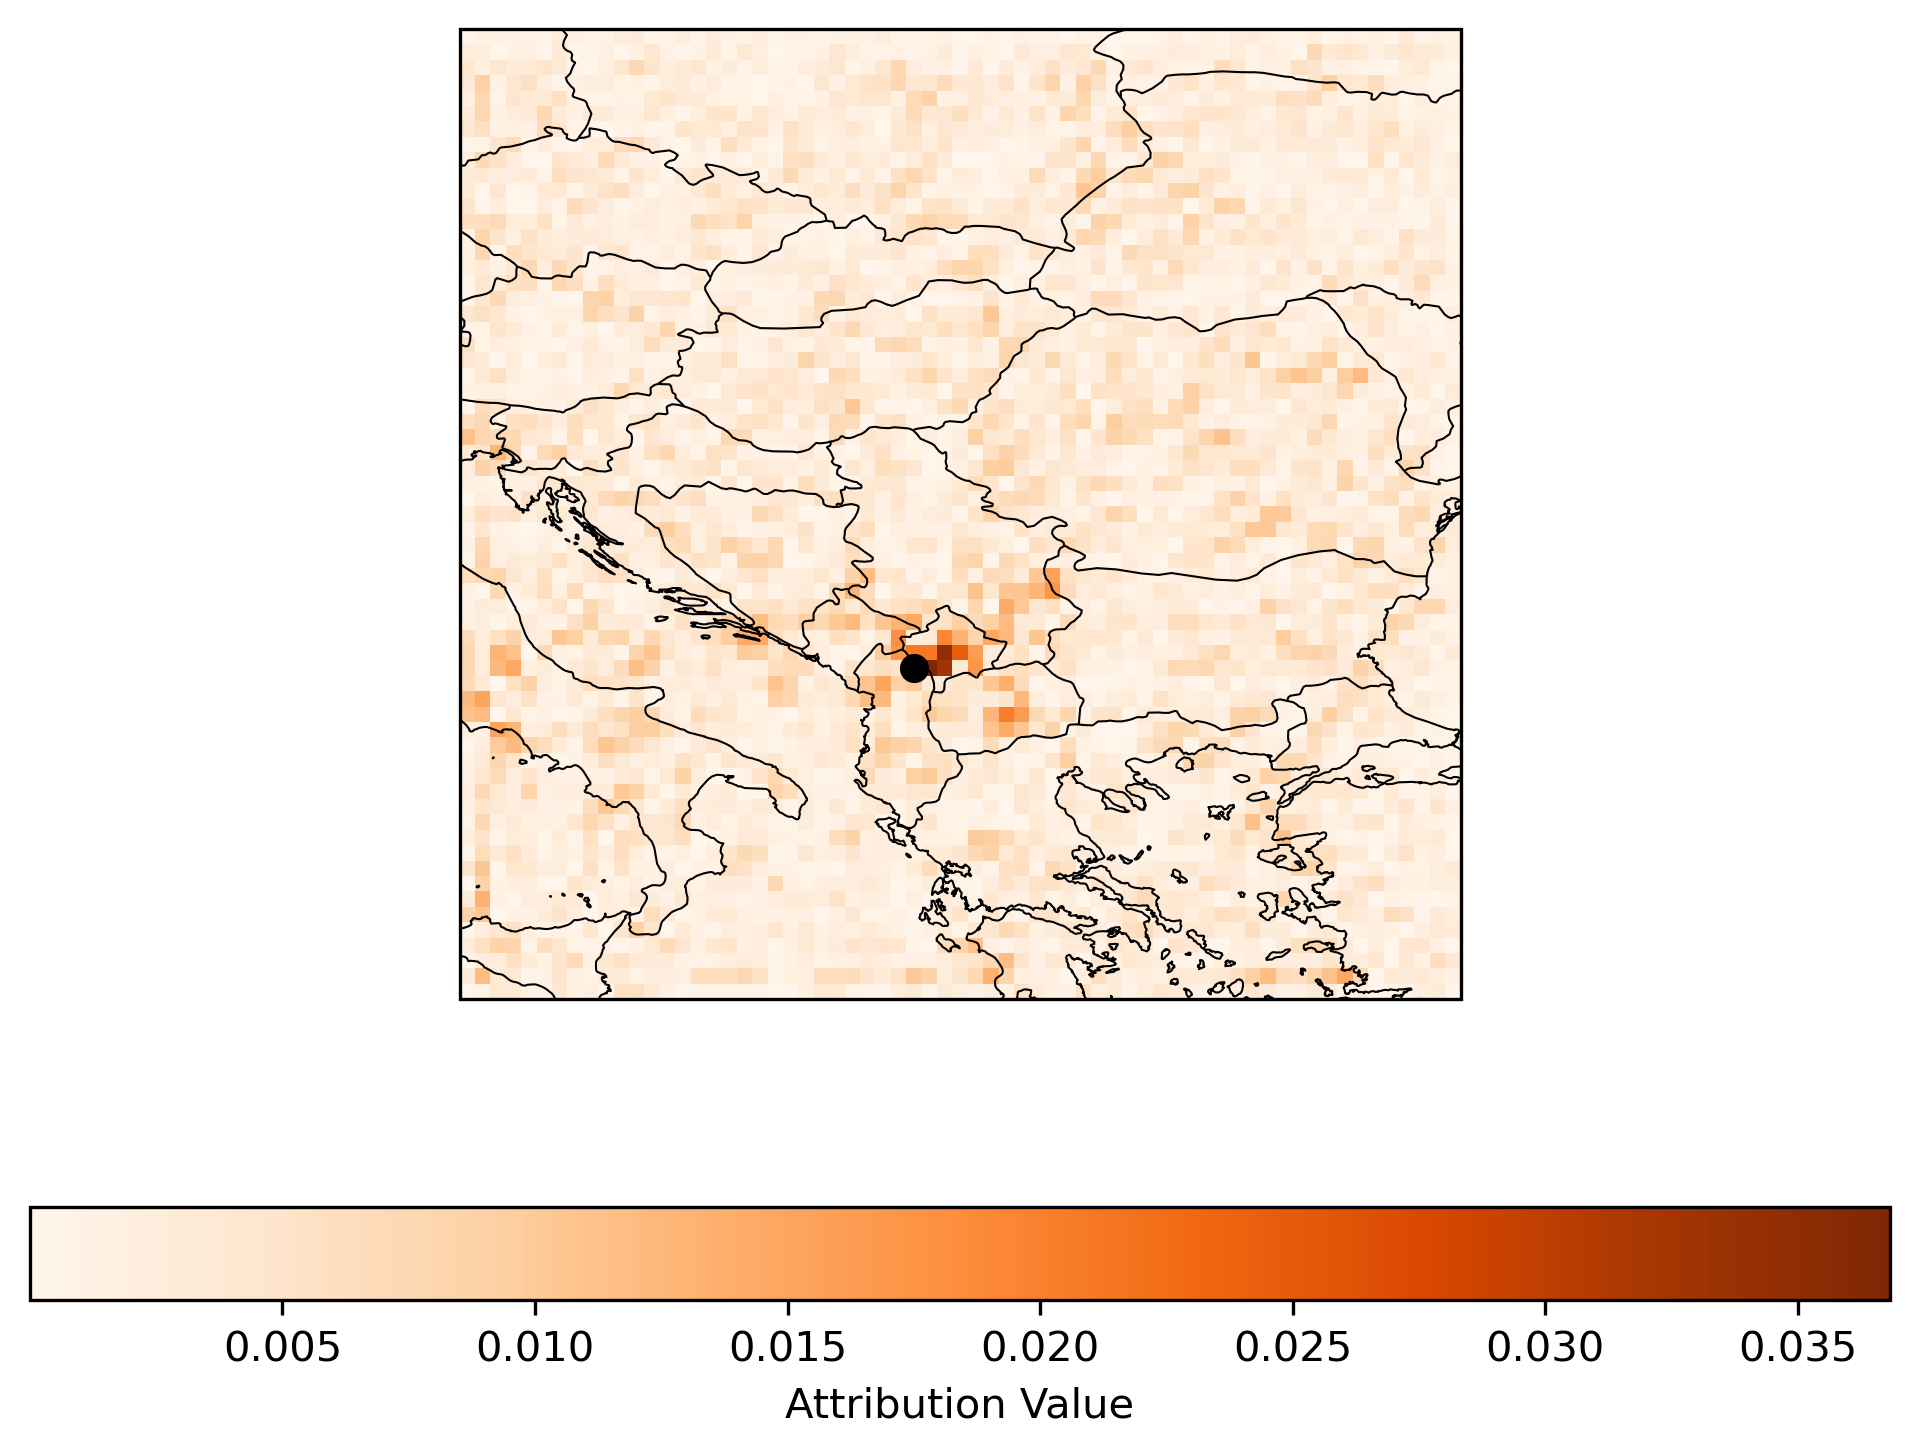

INFO:root:📸 Figure saved to ../outputs/figures/explainability/deepesd_saliency_pixel-2.png


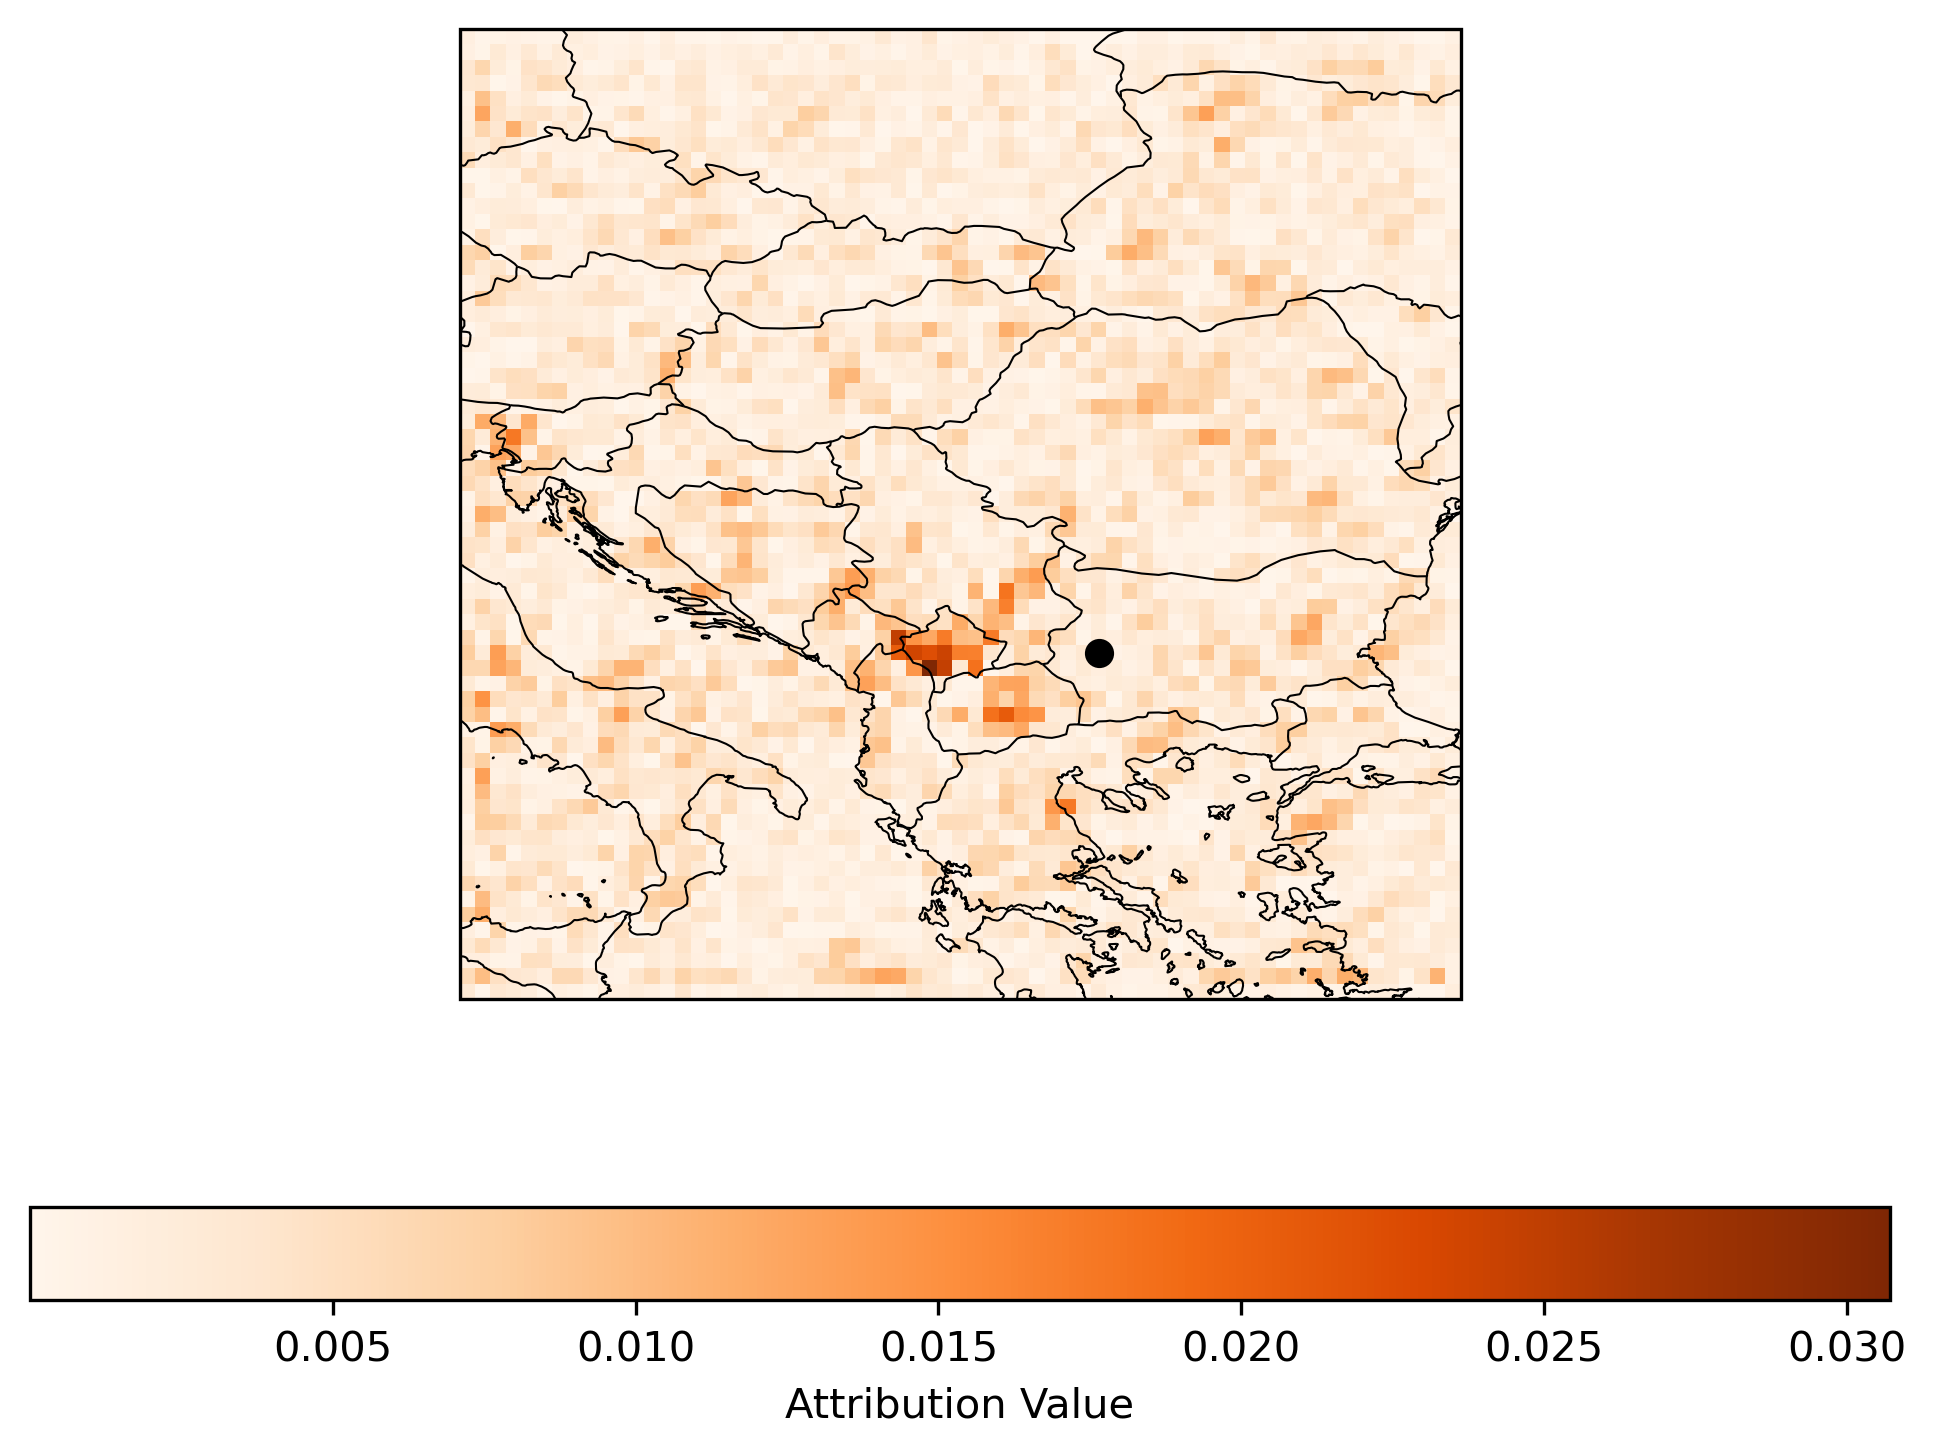

INFO:root:📸 Figure saved to ../outputs/figures/explainability/deepesd_saliency_pixel-3.png


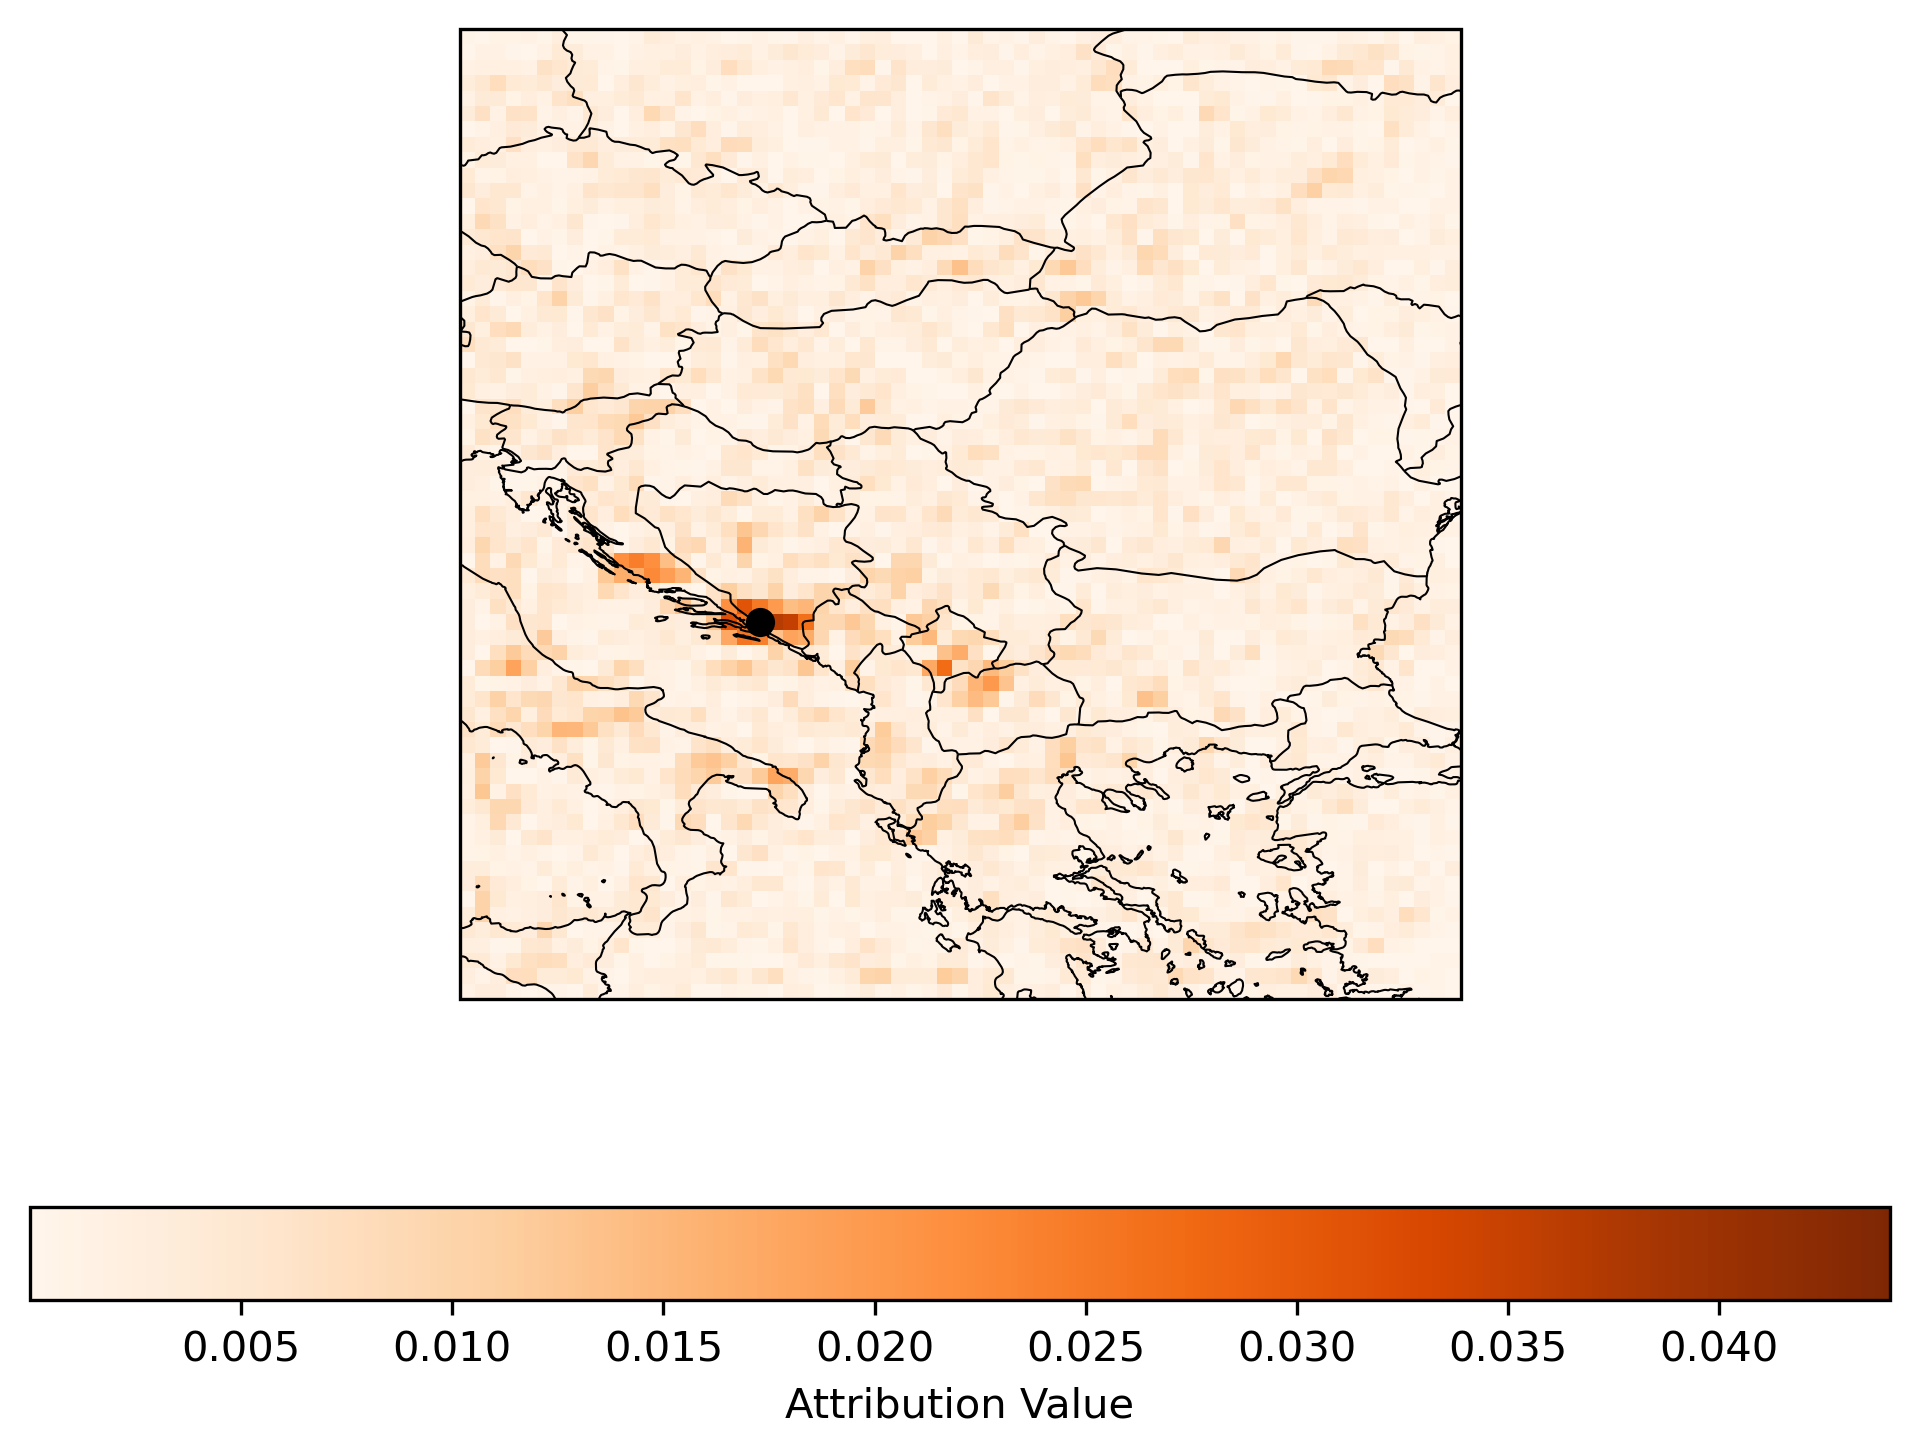

INFO:root:📸 Figure saved to ../outputs/figures/explainability/deepesd_saliency_pixel-4.png


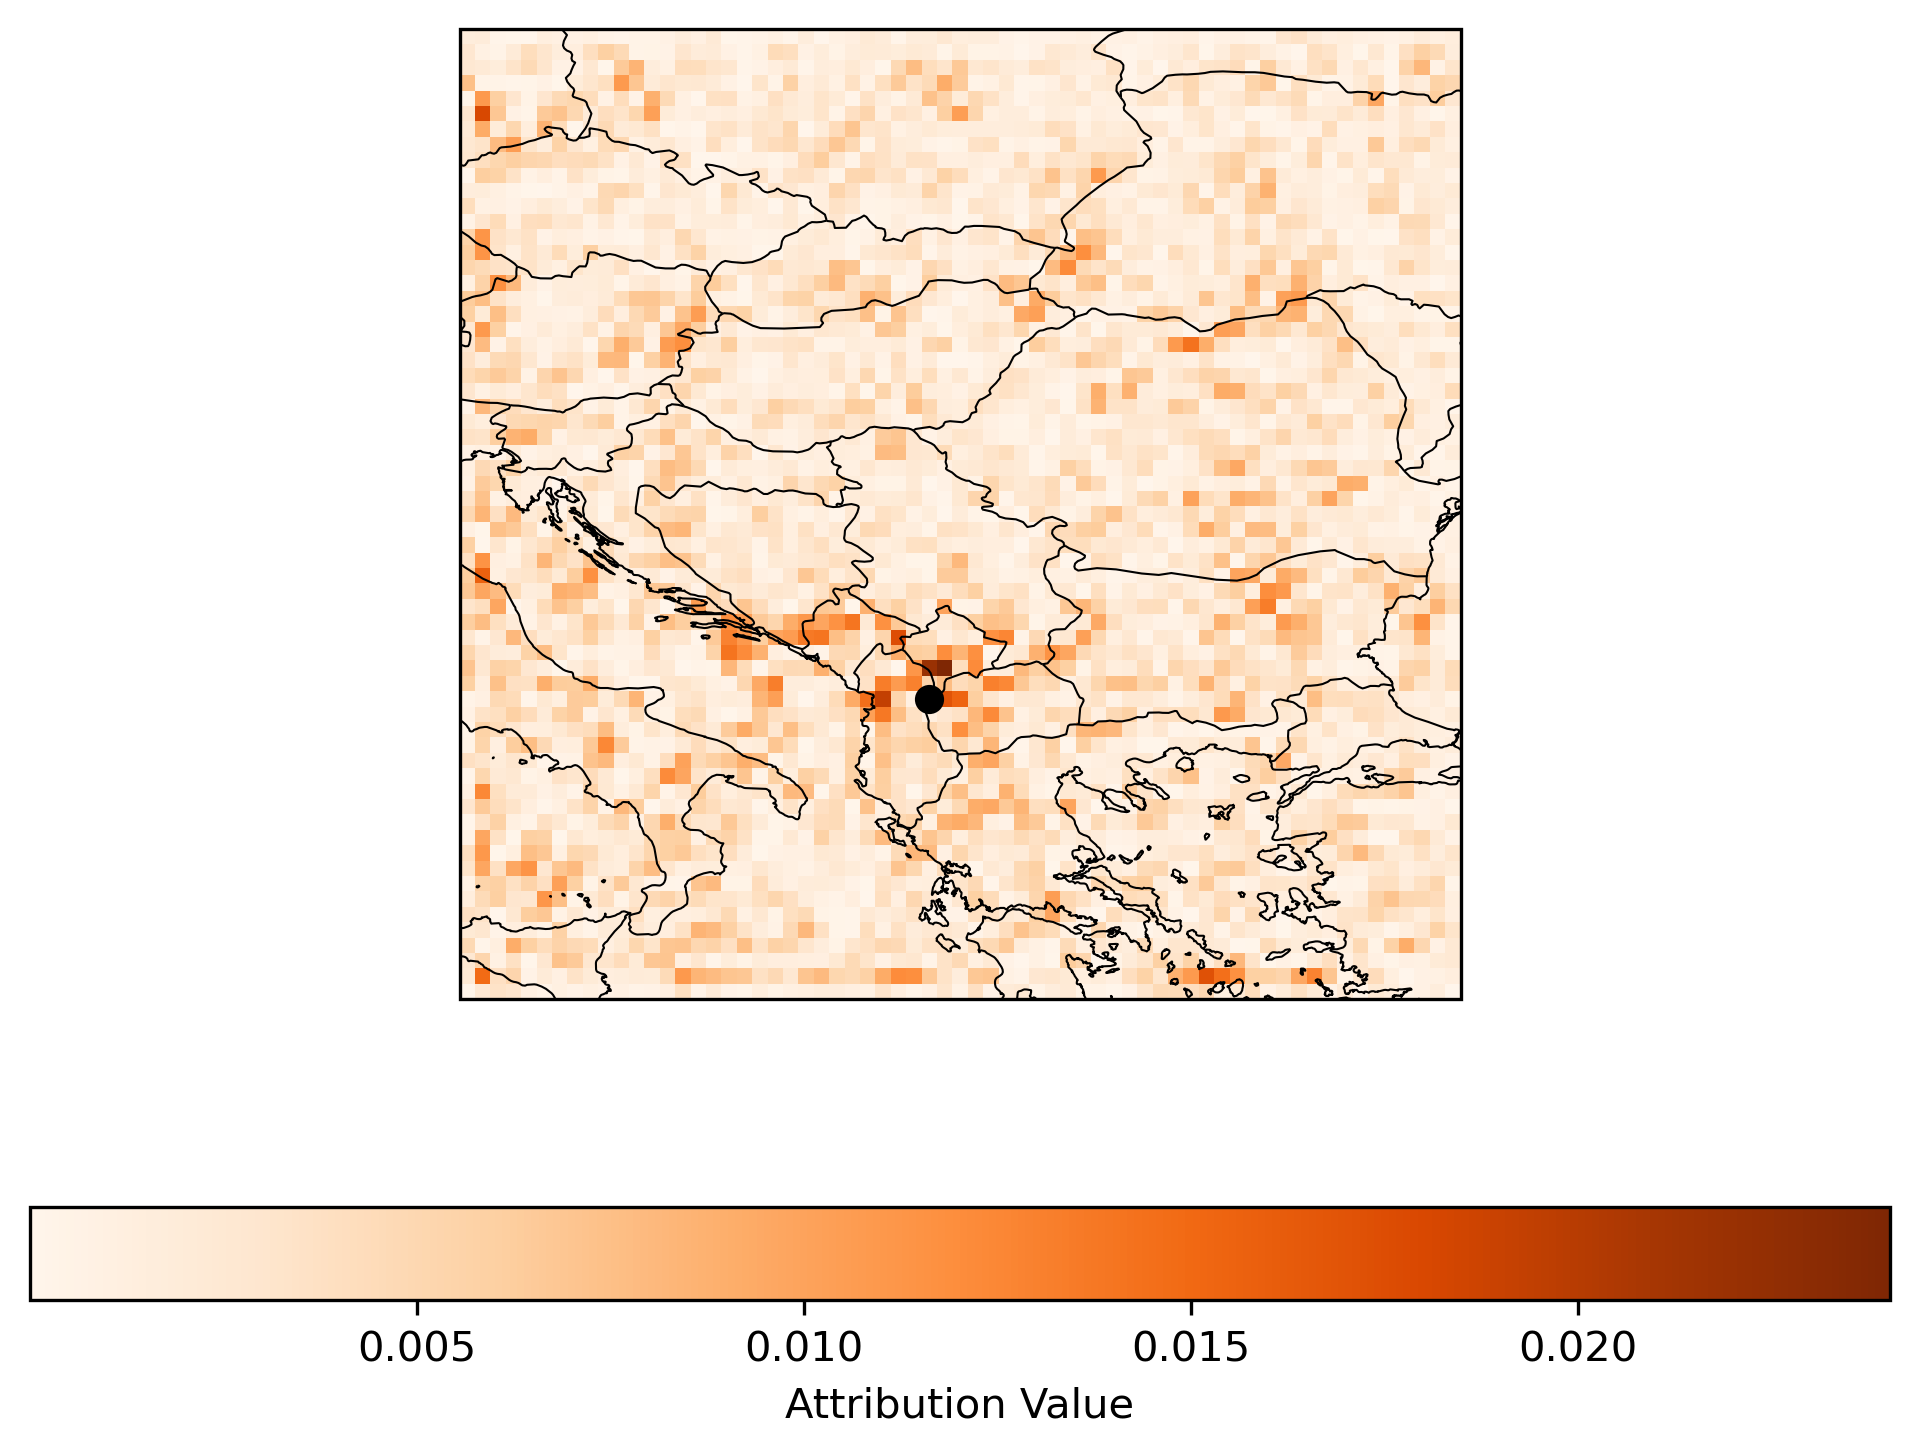

INFO:root:📸 Figure saved to ../outputs/figures/explainability/deepesd_saliency_pixel-5.png


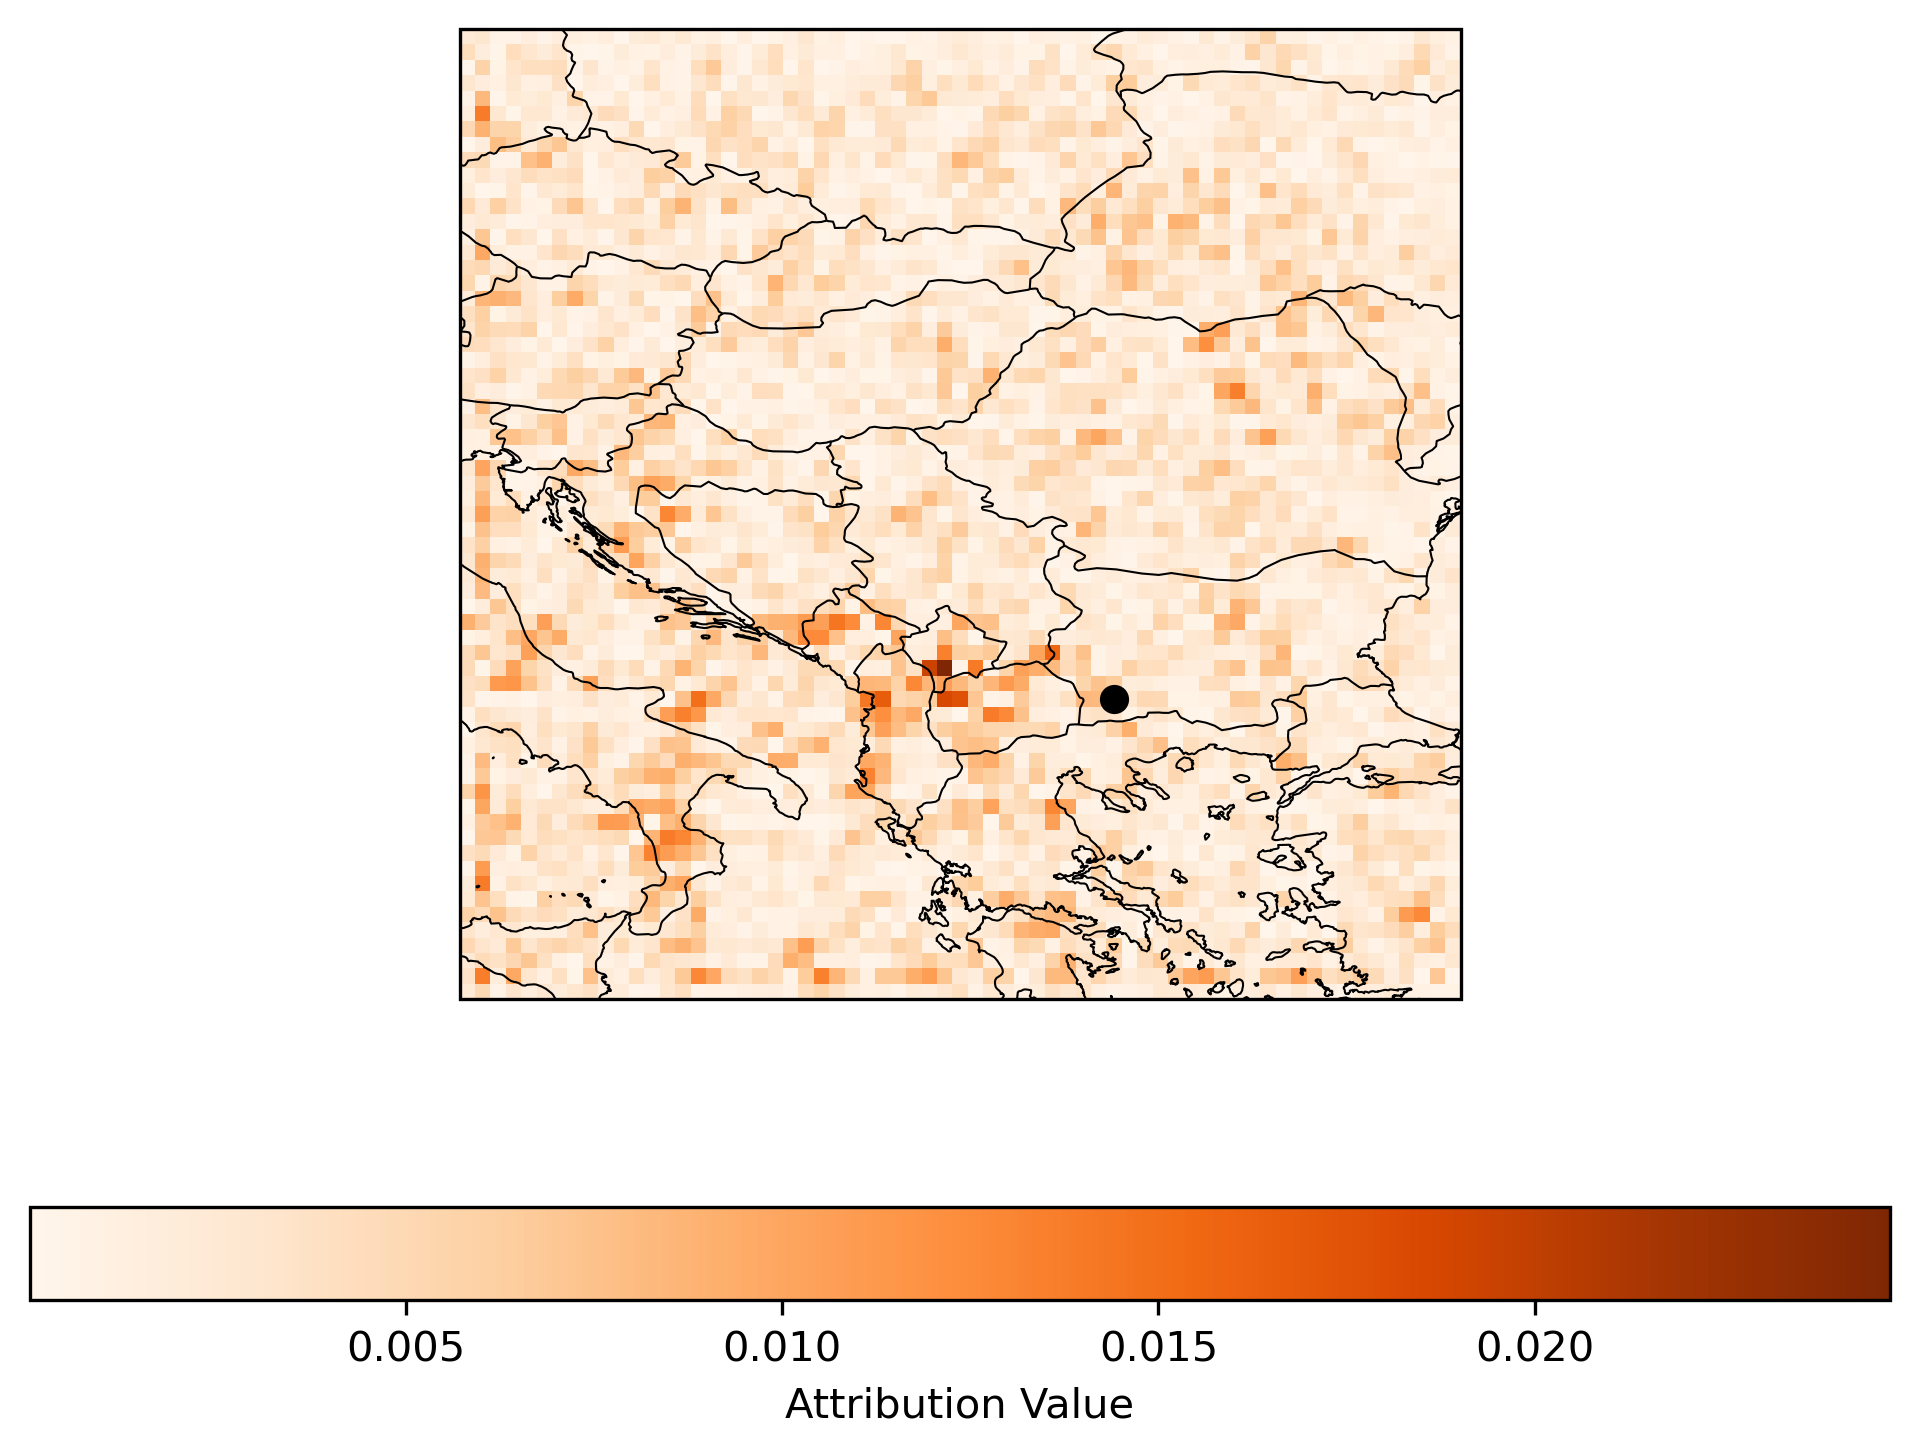

INFO:root:📸 Figure saved to ../outputs/figures/explainability/unet_saliency_pixel-1.png


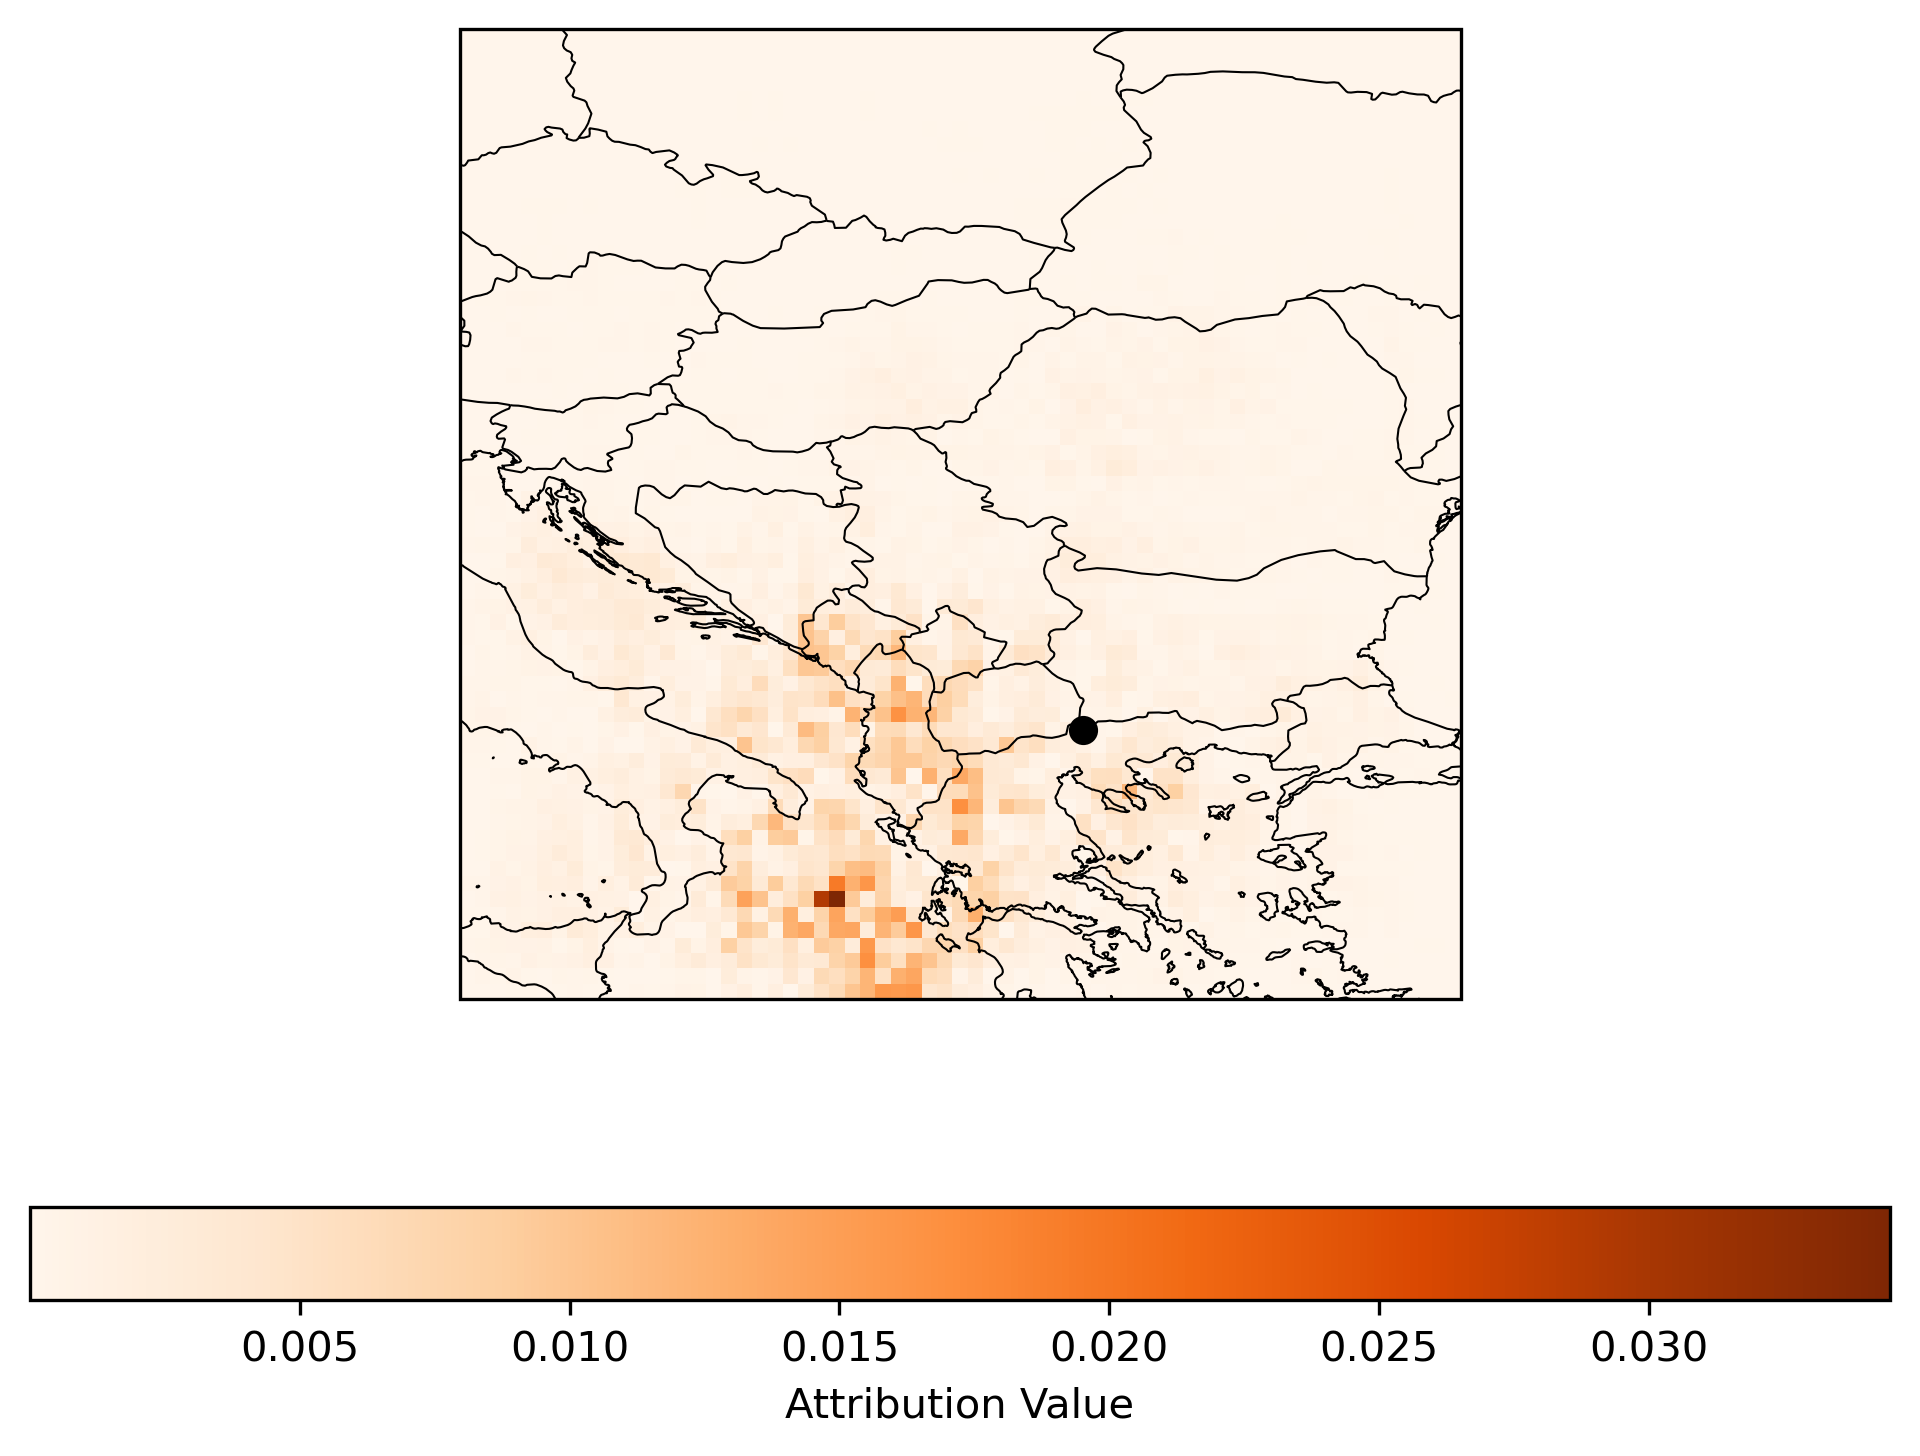

INFO:root:📸 Figure saved to ../outputs/figures/explainability/unet_saliency_pixel-2.png


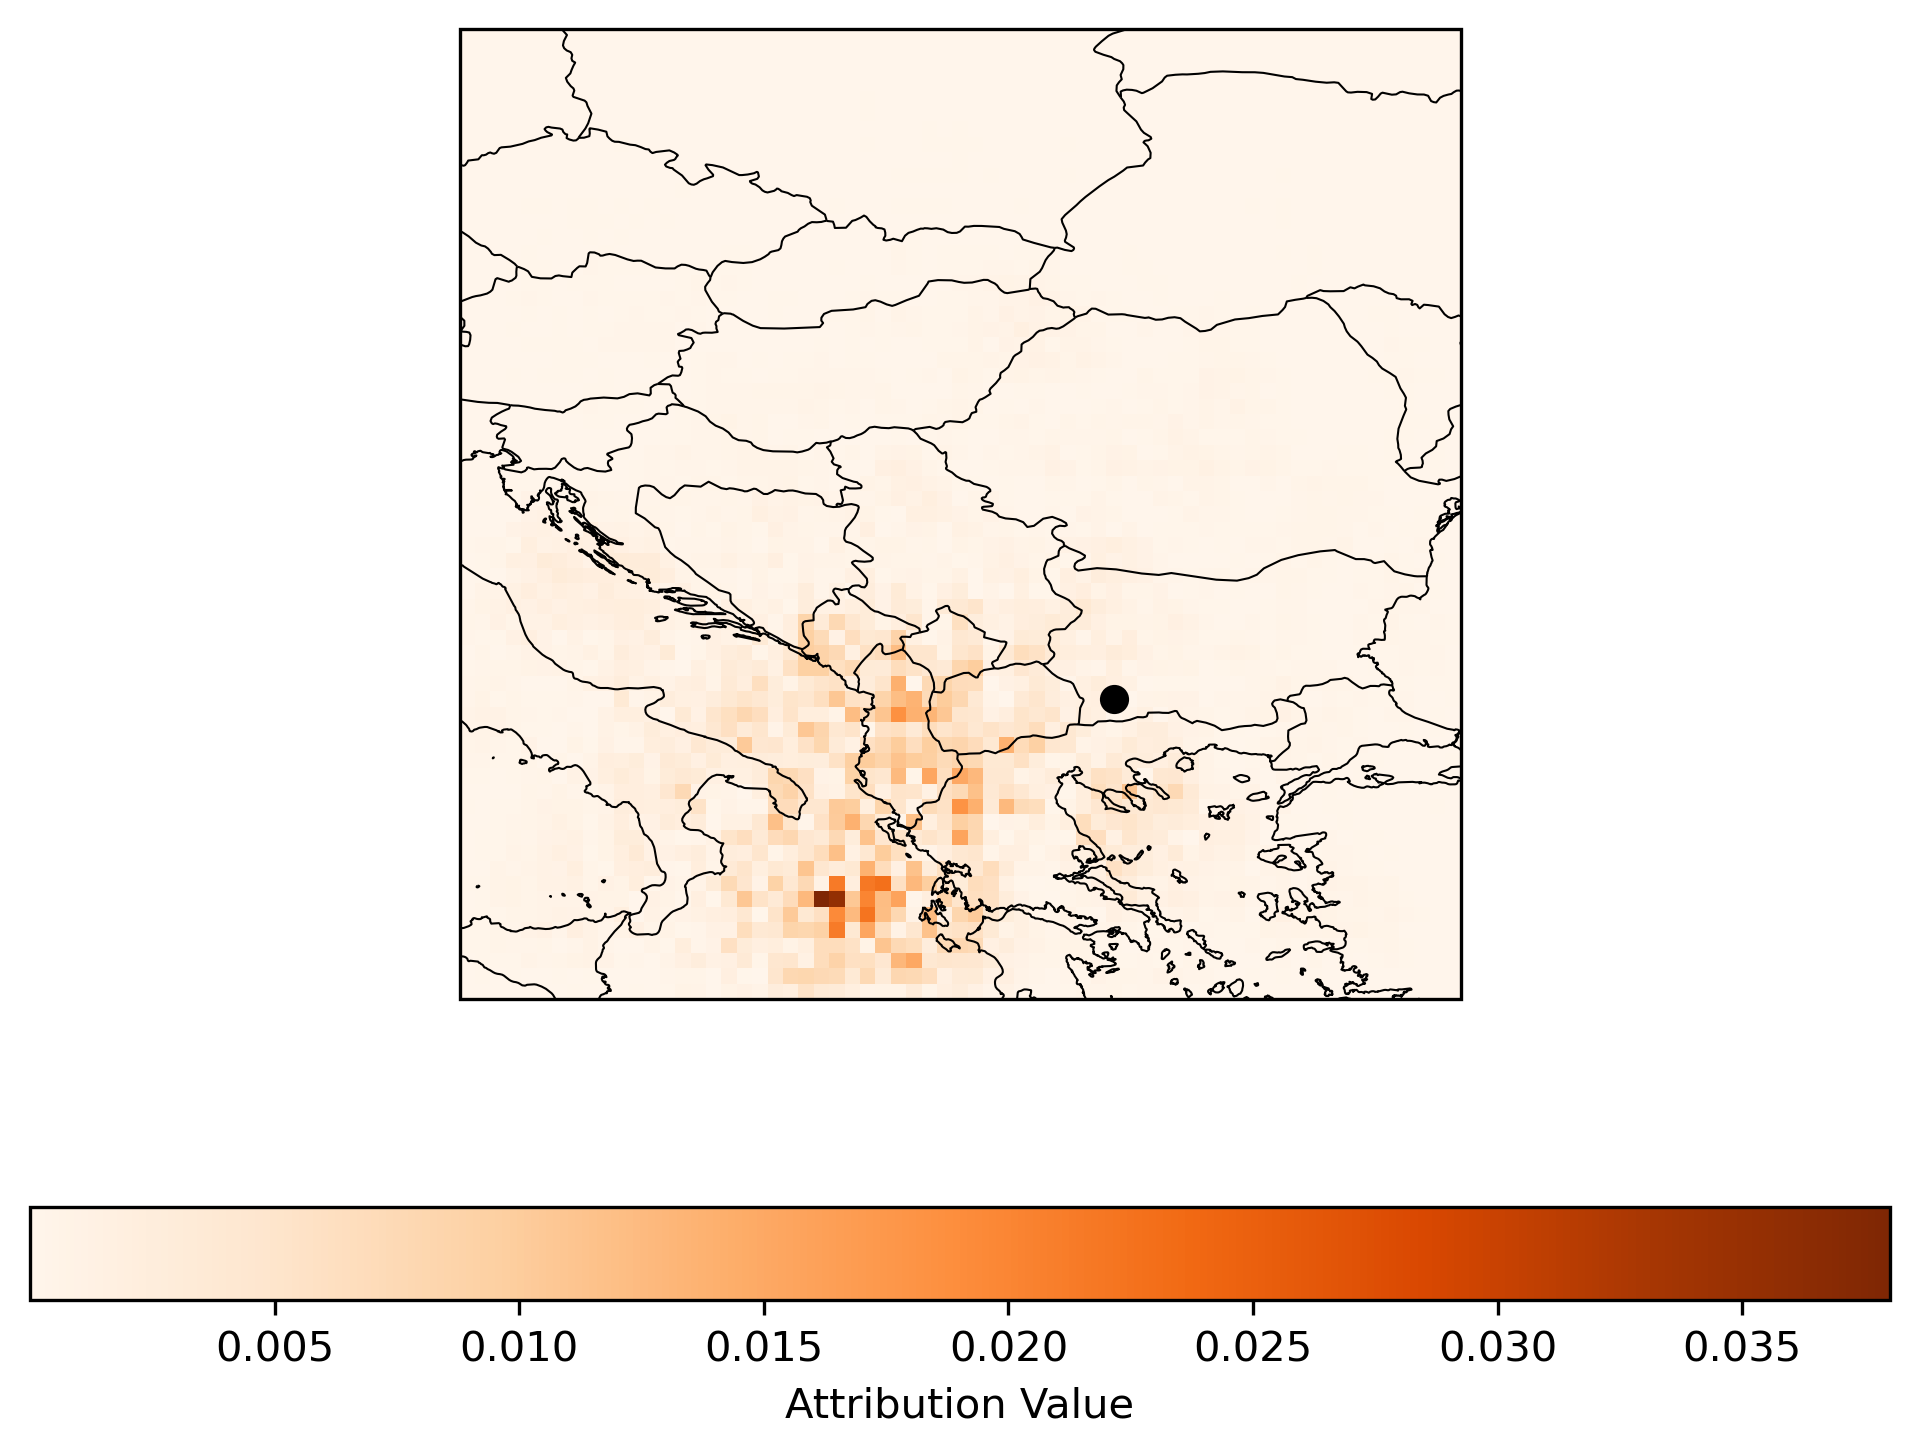

INFO:root:📸 Figure saved to ../outputs/figures/explainability/unet_saliency_pixel-3.png


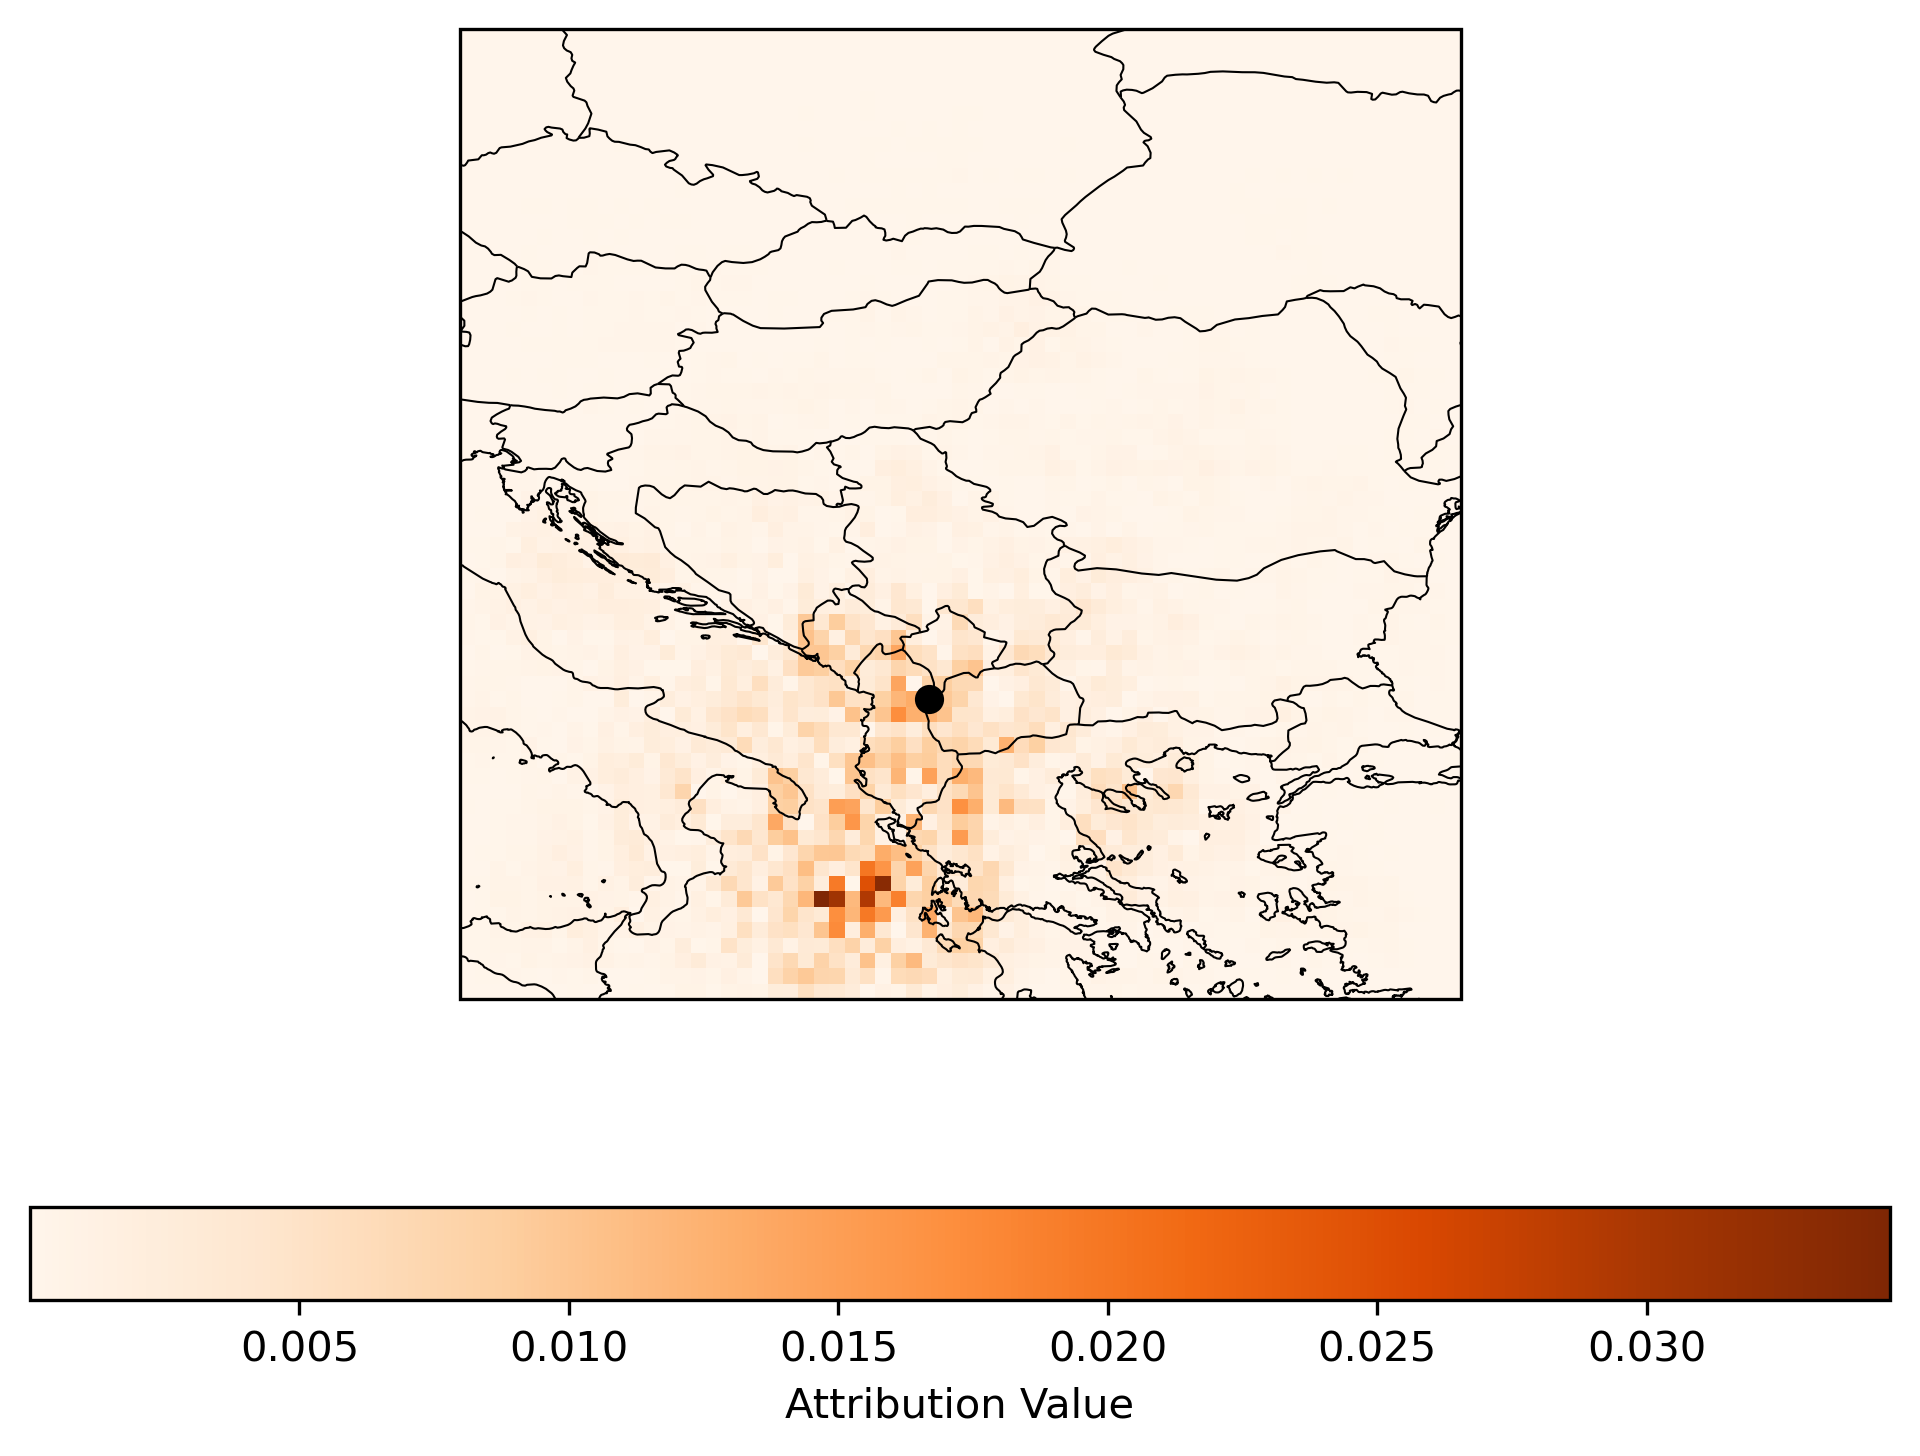

INFO:root:📸 Figure saved to ../outputs/figures/explainability/unet_saliency_pixel-4.png


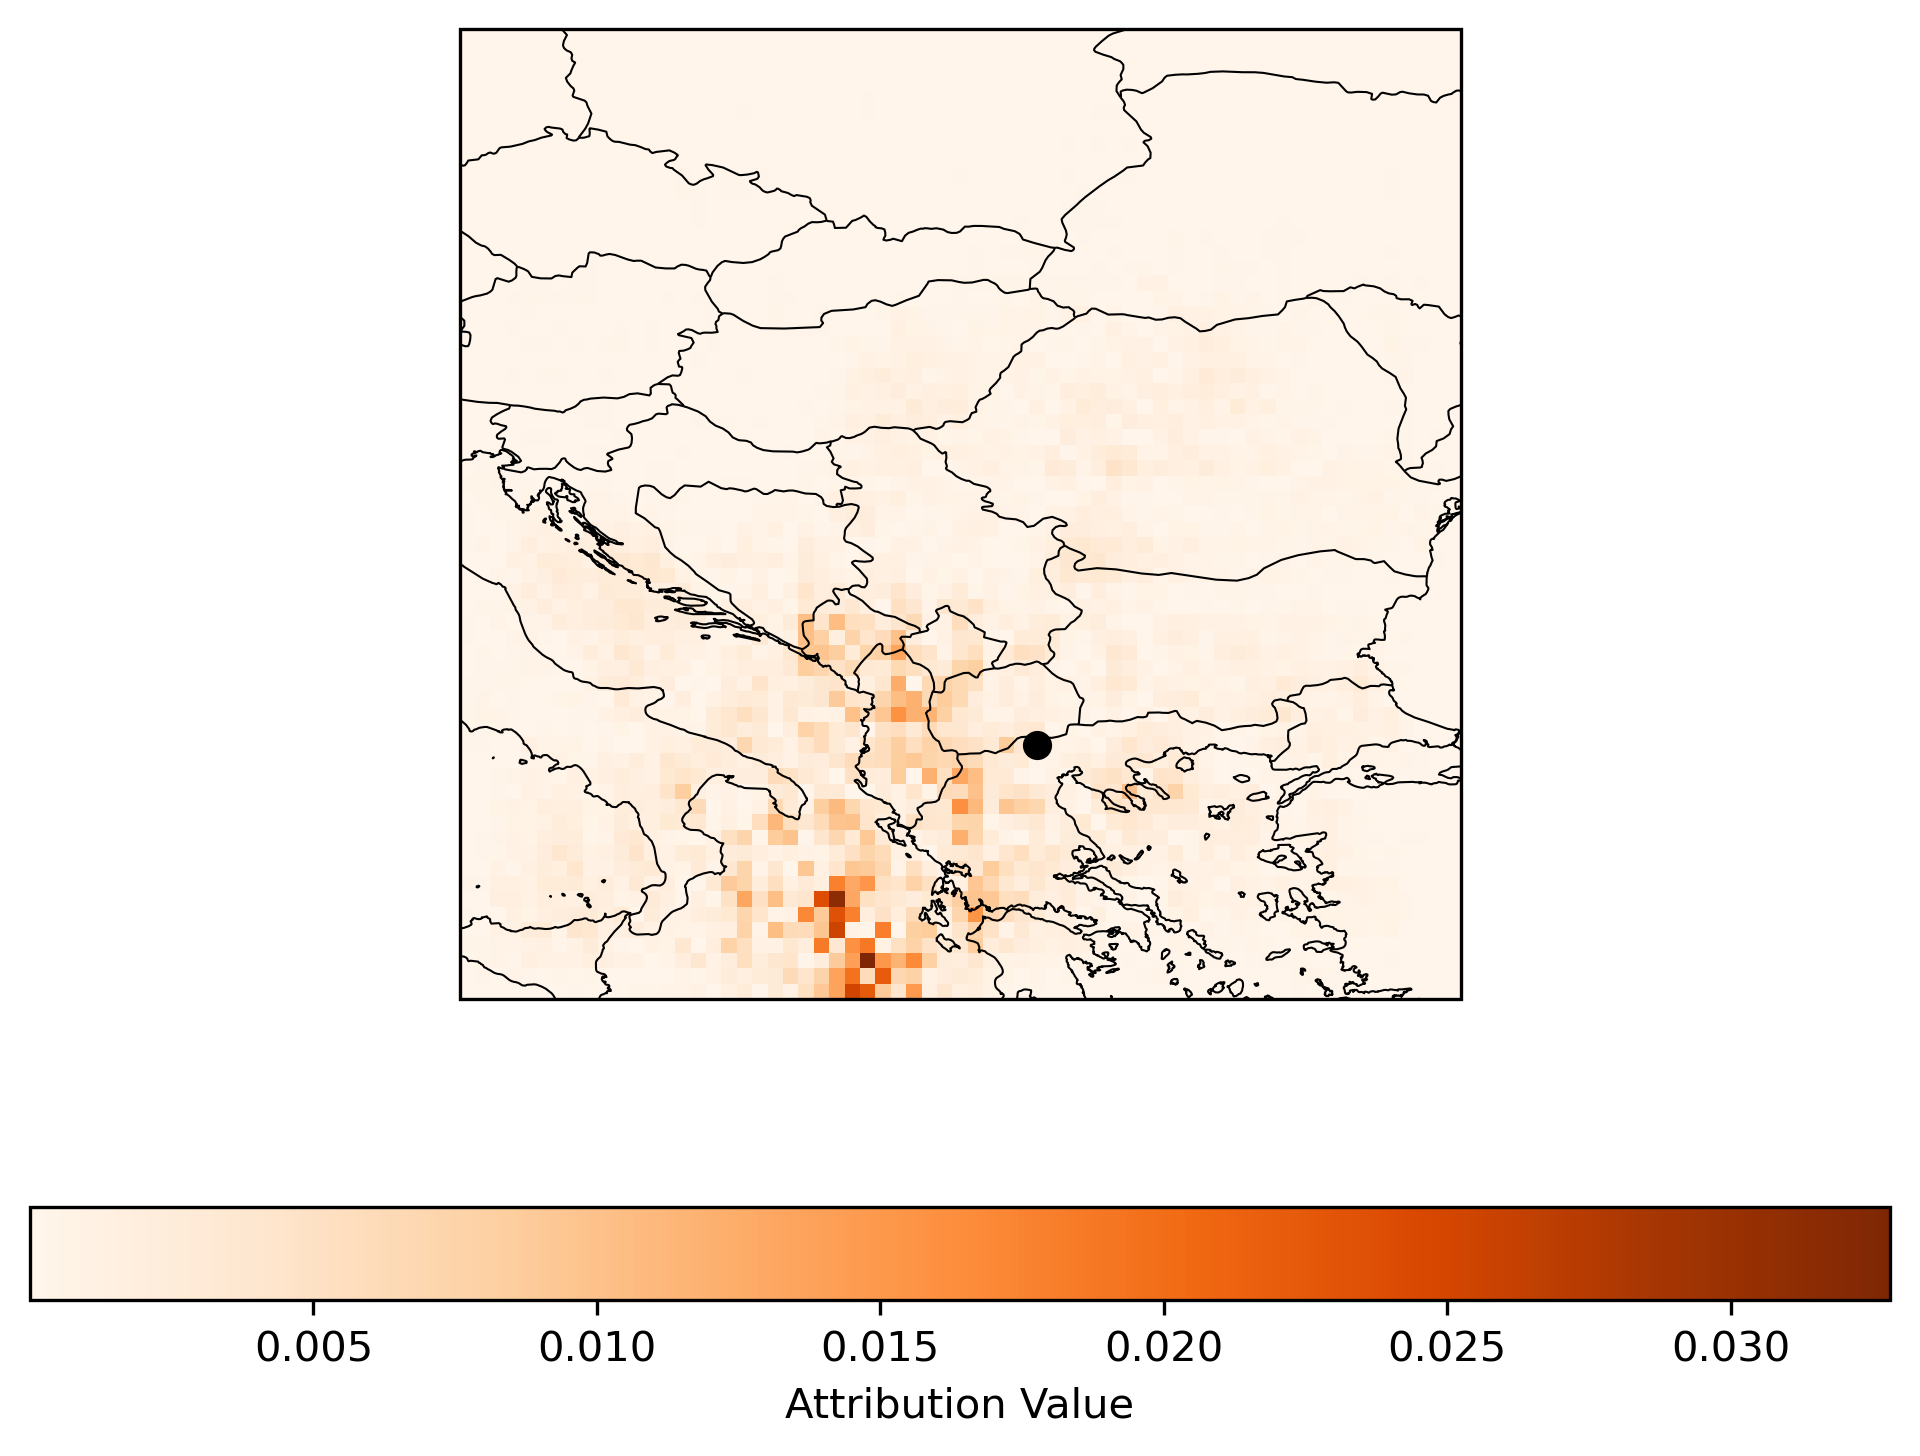

INFO:root:📸 Figure saved to ../outputs/figures/explainability/unet_saliency_pixel-5.png


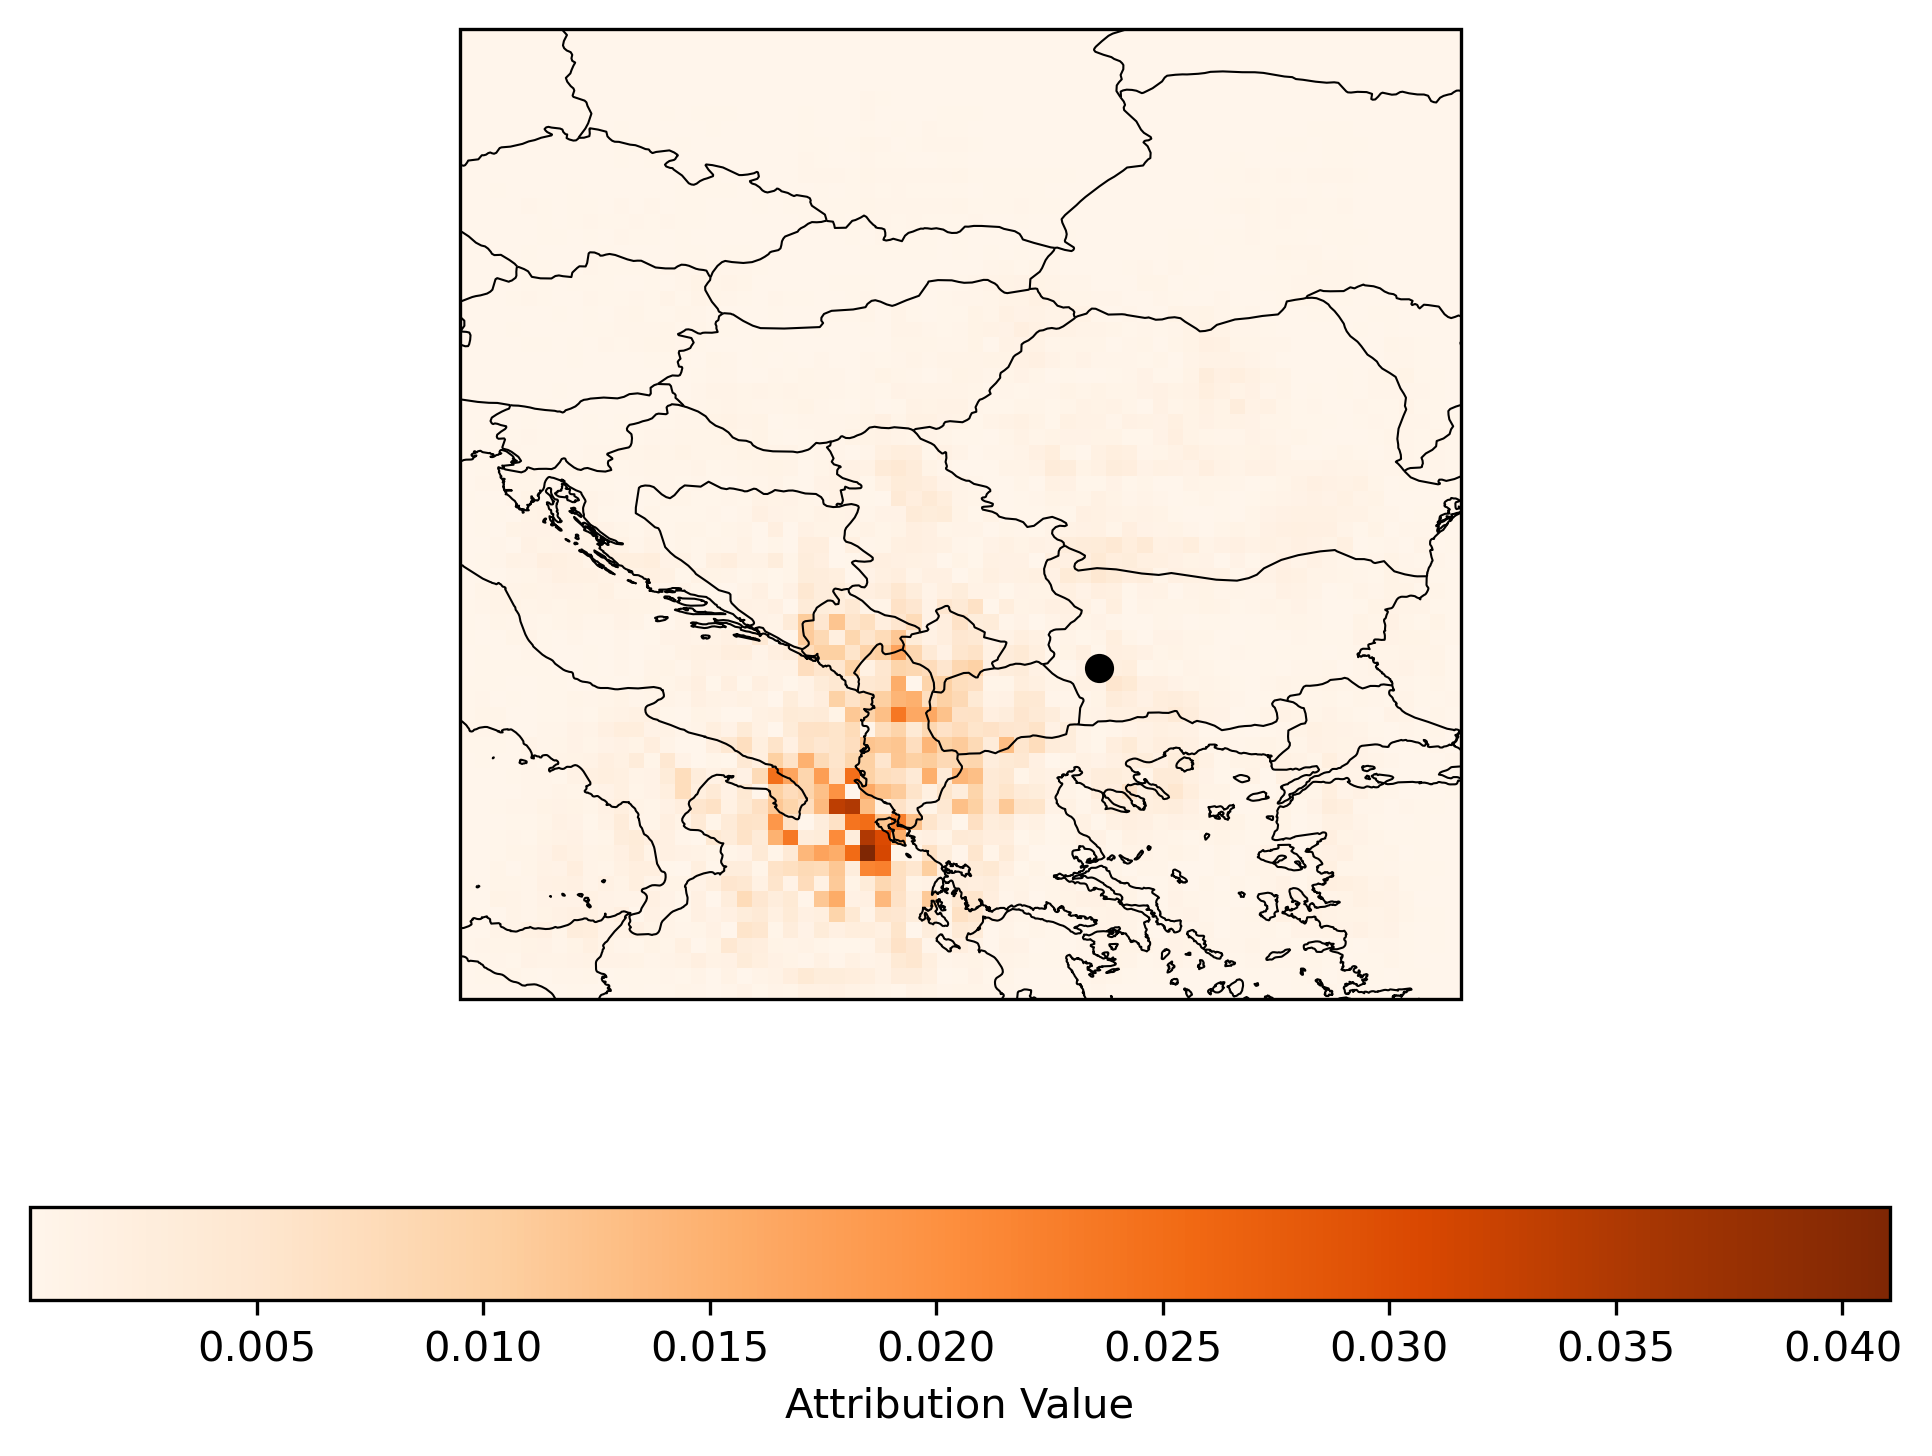

In [9]:
# Generate and save explanation figures
os.makedirs("../outputs/figures/explainability", exist_ok=True)

for i in range(5):
    output_lat_idx, output_lon_idx = deepesd_pixels[i]
    input_coords = df[df["output_lat_idx"] == output_lat_idx][
        df["output_lon_idx"] == output_lon_idx
    ][["input_lat_idx", "input_lon_idx"]].values[0]
    input_lat_idx, input_lon_idx = input_coords

    output_path = plot_explanation_map(
        attributions["DeepESD"]["saliency"][i],
        title="DeepESD - Saliency",
        input_lats=input_lats,
        input_lons=input_lons,
        filename=f"../outputs/figures/explainability/deepesd_saliency_pixel-{i+1}.png",
        pixel_coords=(input_lat_idx, input_lon_idx),
    )
    logging.info(f"📸 Figure saved to {output_path}")
    display(Image(output_path))

    output_path = plot_explanation_map(
        attributions["DeepESD"]["ig"][i],
        title="DeepESD - IntegratedGradients",
        input_lats=input_lats,
        input_lons=input_lons,
        filename=f"../outputs/figures/explainability/deepesd_ig_pixel-{i+1}.png",
        pixel_coords=(input_lat_idx, input_lon_idx),
    )

for i in range(5):
    output_lat_idx, output_lon_idx = unet_pixels[i]
    input_coords = df[df["output_lat_idx"] == output_lat_idx][
        df["output_lon_idx"] == output_lon_idx
    ][["input_lat_idx", "input_lon_idx"]].values[0]
    input_lat_idx, input_lon_idx = input_coords

    output_path = plot_explanation_map(
        attributions["UNet"]["saliency"][i],
        title="UNet - Saliency",
        input_lats=input_lats,
        input_lons=input_lons,
        filename=f"../outputs/figures/explainability/unet_saliency_pixel-{i+1}.png",
        pixel_coords=(input_lat_idx, input_lon_idx),
    )
    logging.info(f"📸 Figure saved to {output_path}")
    display(Image(output_path))

    output_path = plot_explanation_map(
        attributions["UNet"]["ig"][i],
        title="UNet - IntegratedGradients",
        input_lats=input_lats,
        input_lons=input_lons,
        filename=f"../outputs/figures/explainability/unet_ig_pixel-{i+1}.png",
        pixel_coords=(input_lat_idx, input_lon_idx),
    )